In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from itertools import product
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [2]:
from game_theory import GameTheoreticCommunityDetection

Running grid search...

Testing: internal_weight=0.3, external_penalty=1.0, size_penalty=0.05
Average ARI: 0.3634, NMI: 0.4688, Modularity: 0.3432
Average number of communities: 3, Example sizes: [11, 5, 14, 4]

Testing: internal_weight=0.3, external_penalty=1.0, size_penalty=0.1
Average ARI: 0.6257, NMI: 0.6608, Modularity: 0.4376
Average number of communities: 3, Example sizes: [11, 5, 14, 4]

Testing: internal_weight=0.3, external_penalty=1.0, size_penalty=0.15
Average ARI: 0.5673, NMI: 0.6304, Modularity: 0.4407
Average number of communities: 3, Example sizes: [11, 5, 14, 4]

Testing: internal_weight=0.3, external_penalty=1.0, size_penalty=0.2
Average ARI: 0.2098, NMI: 0.3533, Modularity: 0.2656
Average number of communities: 3, Example sizes: [11, 5, 14, 4]

Testing: internal_weight=0.3, external_penalty=1.5, size_penalty=0.05
Average ARI: 0.5673, NMI: 0.6304, Modularity: 0.4407
Average number of communities: 3, Example sizes: [11, 5, 18]

Testing: internal_weight=0.3, external_pe

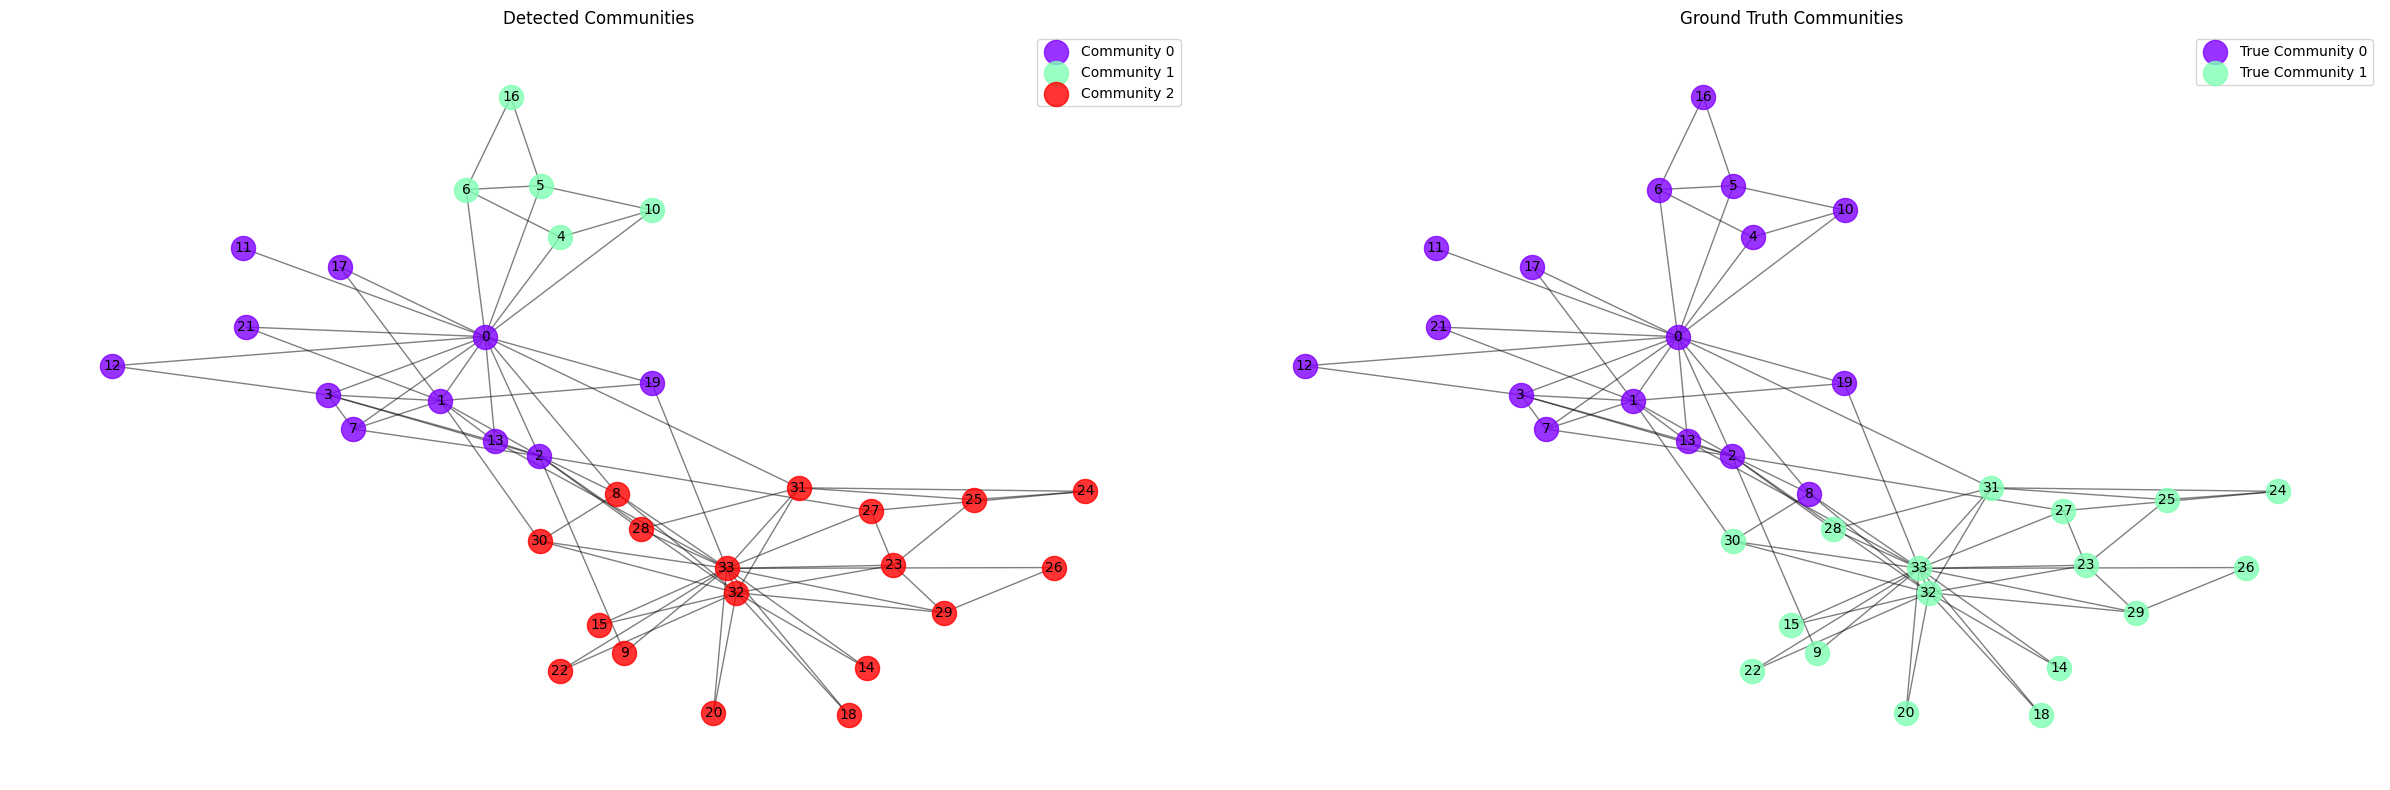

In [3]:
# Load the benchmark graph
G = nx.karate_club_graph()

# Ground truth
true_partition = {node: 0 if G.nodes[node]['club'] == 'Mr. Hi' else 1 for node in G.nodes()}

# Define expanded parameter grid
param_grid = {
    'internal_weight': [0.3, 0.5, 0.7],
    'external_penalty': [1.0, 1.5, 2.0],
    'size_penalty': [0.05, 0.1, 0.15, 0.2]
}

best_ari = -1
best_params = None
best_metrics = None
best_detector = None

# Number of runs per parameter set to account for randomness
num_runs = 3

# Grid search
print("Running grid search...")
for internal_weight, external_penalty, size_penalty in product(
    param_grid['internal_weight'], param_grid['external_penalty'], param_grid['size_penalty']
):
    print(f"\nTesting: internal_weight={internal_weight}, external_penalty={external_penalty}, size_penalty={size_penalty}")
    ari_scores = []
    metrics_list = []
    
    for run in range(num_runs):
        detector = GameTheoreticCommunityDetection(
            G, internal_weight=internal_weight, external_penalty=external_penalty, size_penalty=size_penalty
        )
        partition = detector.run(init_method="singleton")
        metrics = detector.calculate_community_metrics(ground_truth=true_partition)
        ari_scores.append(metrics['ari'])
        metrics_list.append(metrics)
    
    # Average metrics over runs
    avg_ari = np.mean(ari_scores)
    avg_metrics = {
        'ari': avg_ari,
        'nmi': np.mean([m['nmi'] for m in metrics_list]),
        'modularity': np.mean([m['modularity'] for m in metrics_list]),
        'num_communities': int(np.mean([m['num_communities'] for m in metrics_list])),
        'sizes': metrics_list[0]['sizes'],  # Take sizes from last run (may vary slightly)
        'internal_densities': np.mean([np.mean(m['internal_densities']) for m in metrics_list]),
        'external_densities': np.mean([np.mean(m['external_densities']) for m in metrics_list])
    }
    
    print(f"Average ARI: {avg_ari:.4f}, NMI: {avg_metrics['nmi']:.4f}, Modularity: {avg_metrics['modularity']:.4f}")
    print(f"Average number of communities: {avg_metrics['num_communities']}, Example sizes: {avg_metrics['sizes']}")
    
    if avg_ari > best_ari:
        best_ari = avg_ari
        best_params = {
            'internal_weight': internal_weight,
            'external_penalty': external_penalty,
            'size_penalty': size_penalty
        }
        best_metrics = avg_metrics
        best_detector = detector  # Save the last detector for visualization

# Report best results
print("\nBest Parameters:")
print(f"internal_weight: {best_params['internal_weight']}")
print(f"external_penalty: {best_params['external_penalty']}")
print(f"size_penalty: {best_params['size_penalty']}")
print("\nBest Metrics (Averaged):")
print(f"Number of communities: {best_metrics['num_communities']}")
print(f"Example community sizes: {best_metrics['sizes']}")
print(f"Modularity: {best_metrics['modularity']:.4f}")
print(f"Normalized Mutual Information (NMI): {best_metrics['nmi']:.4f}")
print(f"Adjusted Rand Index (ARI): {best_metrics['ari']:.4f}")
print(f"Average internal density: {best_metrics['internal_densities']:.4f}")
print(f"Average external density: {best_metrics['external_densities']:.4f}")

# Visualize the best result
plt = best_detector.visualize(ground_truth=true_partition)


Community Metrics:
Number of communities: 4
Community sizes: [11, 5, 14, 4]
Communities: [[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [4, 5, 6, 10, 16], [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33], [24, 25, 28, 31]]
Modularity: 0.4439
Normalized Mutual Information (NMI): 0.6000
Adjusted Rand Index (ARI): 0.5089
Average internal density: 0.7737
Average external density: 0.1296


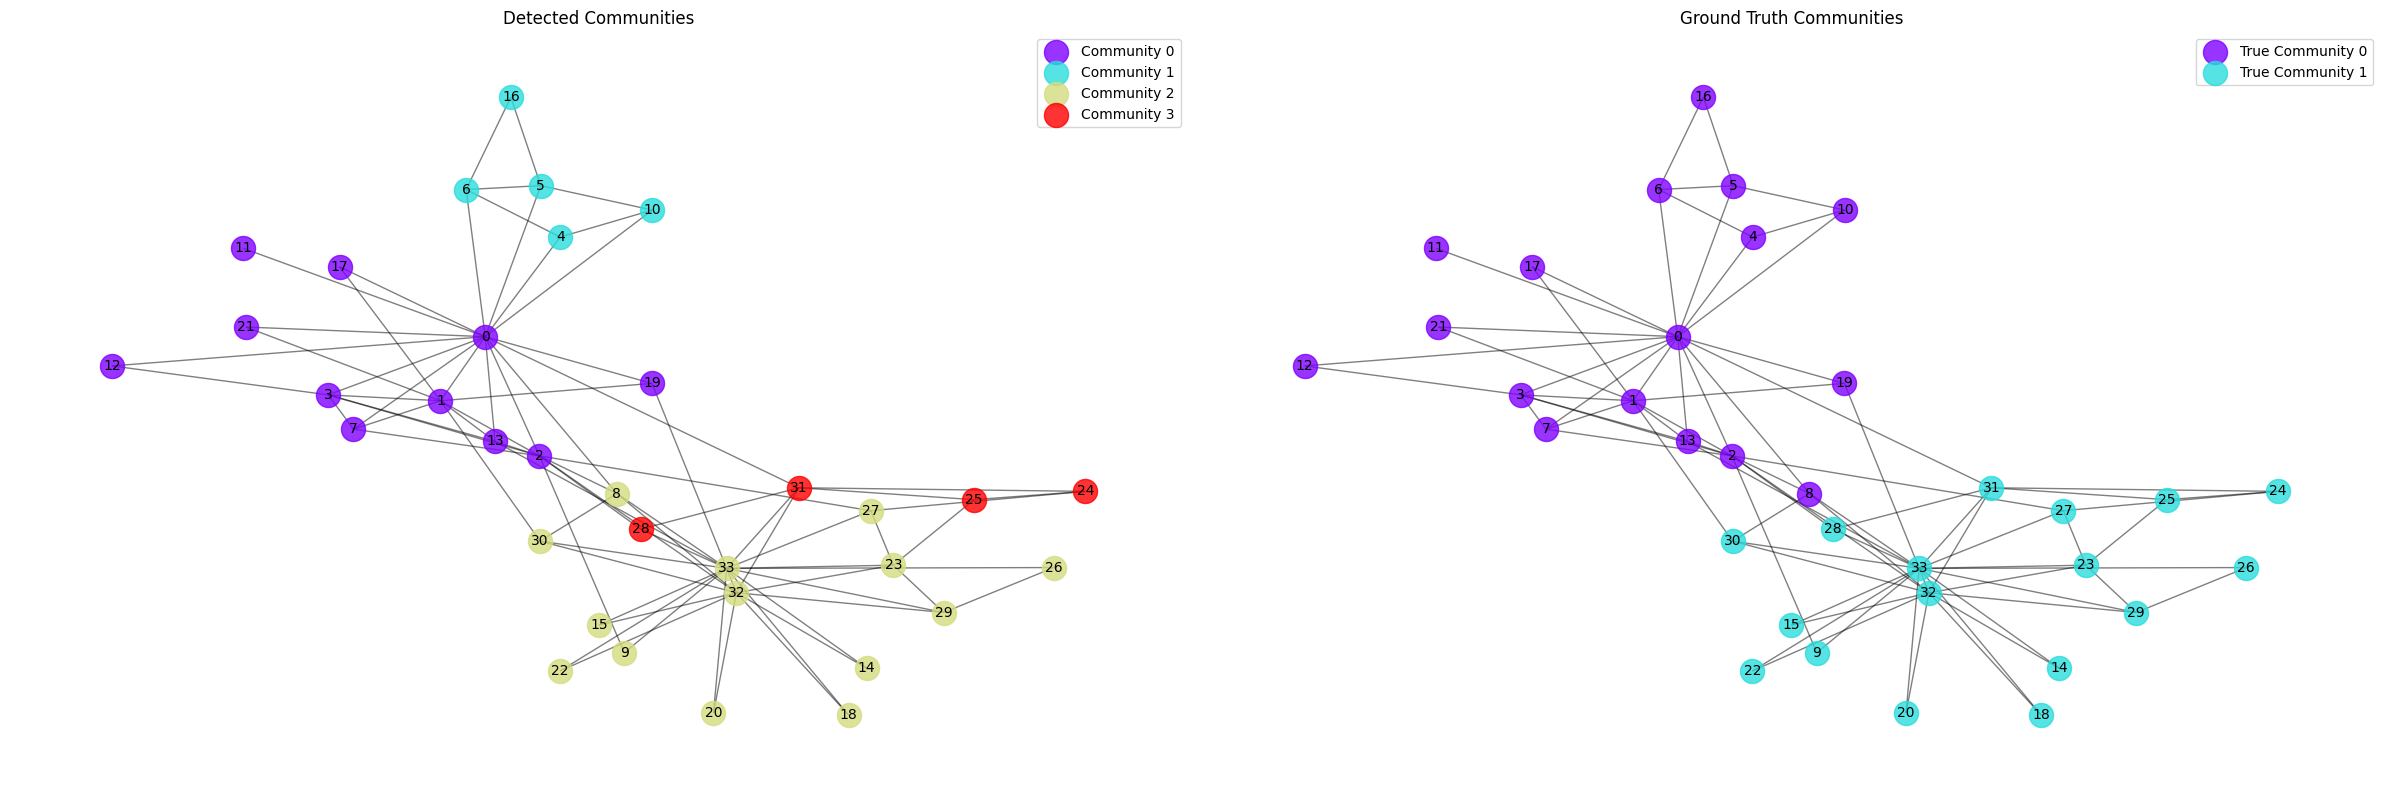

In [4]:
# Load the benchmark graph
G = nx.karate_club_graph()

# Ground truth
true_partition = {node: 0 if G.nodes[node]['club'] == 'Mr. Hi' else 1 for node in G.nodes()}

detector = GameTheoreticCommunityDetection(G)
partition = detector.run(init_method="singleton")
metrics = detector.calculate_community_metrics(ground_truth=true_partition)

print("\nCommunity Metrics:")
print(f"Number of communities: {metrics['num_communities']}")
print(f"Community sizes: {metrics['sizes']}")
print(f"Communities: {[sorted(metrics['communities'][i]) for i in range(metrics['num_communities'])]}")
print(f"Modularity: {metrics['modularity']:.4f}")
print(f"Normalized Mutual Information (NMI): {metrics['nmi']:.4f}")
print(f"Adjusted Rand Index (ARI): {metrics['ari']:.4f}")
print(f"Average internal density: {np.mean(metrics['internal_densities']):.4f}")
print(f"Average external density: {np.mean(metrics['external_densities']):.4f}")

# Visualize the results
plt = detector.visualize(ground_truth=true_partition)

In [5]:
G.nodes(data=True)

NodeDataView({0: {'club': 'Mr. Hi'}, 1: {'club': 'Mr. Hi'}, 2: {'club': 'Mr. Hi'}, 3: {'club': 'Mr. Hi'}, 4: {'club': 'Mr. Hi'}, 5: {'club': 'Mr. Hi'}, 6: {'club': 'Mr. Hi'}, 7: {'club': 'Mr. Hi'}, 8: {'club': 'Mr. Hi'}, 9: {'club': 'Officer'}, 10: {'club': 'Mr. Hi'}, 11: {'club': 'Mr. Hi'}, 12: {'club': 'Mr. Hi'}, 13: {'club': 'Mr. Hi'}, 14: {'club': 'Officer'}, 15: {'club': 'Officer'}, 16: {'club': 'Mr. Hi'}, 17: {'club': 'Mr. Hi'}, 18: {'club': 'Officer'}, 19: {'club': 'Mr. Hi'}, 20: {'club': 'Officer'}, 21: {'club': 'Mr. Hi'}, 22: {'club': 'Officer'}, 23: {'club': 'Officer'}, 24: {'club': 'Officer'}, 25: {'club': 'Officer'}, 26: {'club': 'Officer'}, 27: {'club': 'Officer'}, 28: {'club': 'Officer'}, 29: {'club': 'Officer'}, 30: {'club': 'Officer'}, 31: {'club': 'Officer'}, 32: {'club': 'Officer'}, 33: {'club': 'Officer'}})

In [6]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 4}), (0, 2, {'weight': 5}), (0, 3, {'weight': 3}), (0, 4, {'weight': 3}), (0, 5, {'weight': 3}), (0, 6, {'weight': 3}), (0, 7, {'weight': 2}), (0, 8, {'weight': 2}), (0, 10, {'weight': 2}), (0, 11, {'weight': 3}), (0, 12, {'weight': 1}), (0, 13, {'weight': 3}), (0, 17, {'weight': 2}), (0, 19, {'weight': 2}), (0, 21, {'weight': 2}), (0, 31, {'weight': 2}), (1, 2, {'weight': 6}), (1, 3, {'weight': 3}), (1, 7, {'weight': 4}), (1, 13, {'weight': 5}), (1, 17, {'weight': 1}), (1, 19, {'weight': 2}), (1, 21, {'weight': 2}), (1, 30, {'weight': 2}), (2, 3, {'weight': 3}), (2, 7, {'weight': 4}), (2, 8, {'weight': 5}), (2, 9, {'weight': 1}), (2, 13, {'weight': 3}), (2, 27, {'weight': 2}), (2, 28, {'weight': 2}), (2, 32, {'weight': 2}), (3, 7, {'weight': 3}), (3, 12, {'weight': 3}), (3, 13, {'weight': 3}), (4, 6, {'weight': 2}), (4, 10, {'weight': 3}), (5, 6, {'weight': 5}), (5, 10, {'weight': 3}), (5, 16, {'weight': 3}), (6, 16, {'weight': 3}), (8, 30, {'weight': 3


Community Metrics:
Number of communities: 3
Community sizes: [4, 4, 4]
Communities: [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
Modularity: 0.6000
Normalized Mutual Information (NMI): 1.0000
Adjusted Rand Index (ARI): 1.0000
Average internal density: 1.1667
Average external density: 0.0625


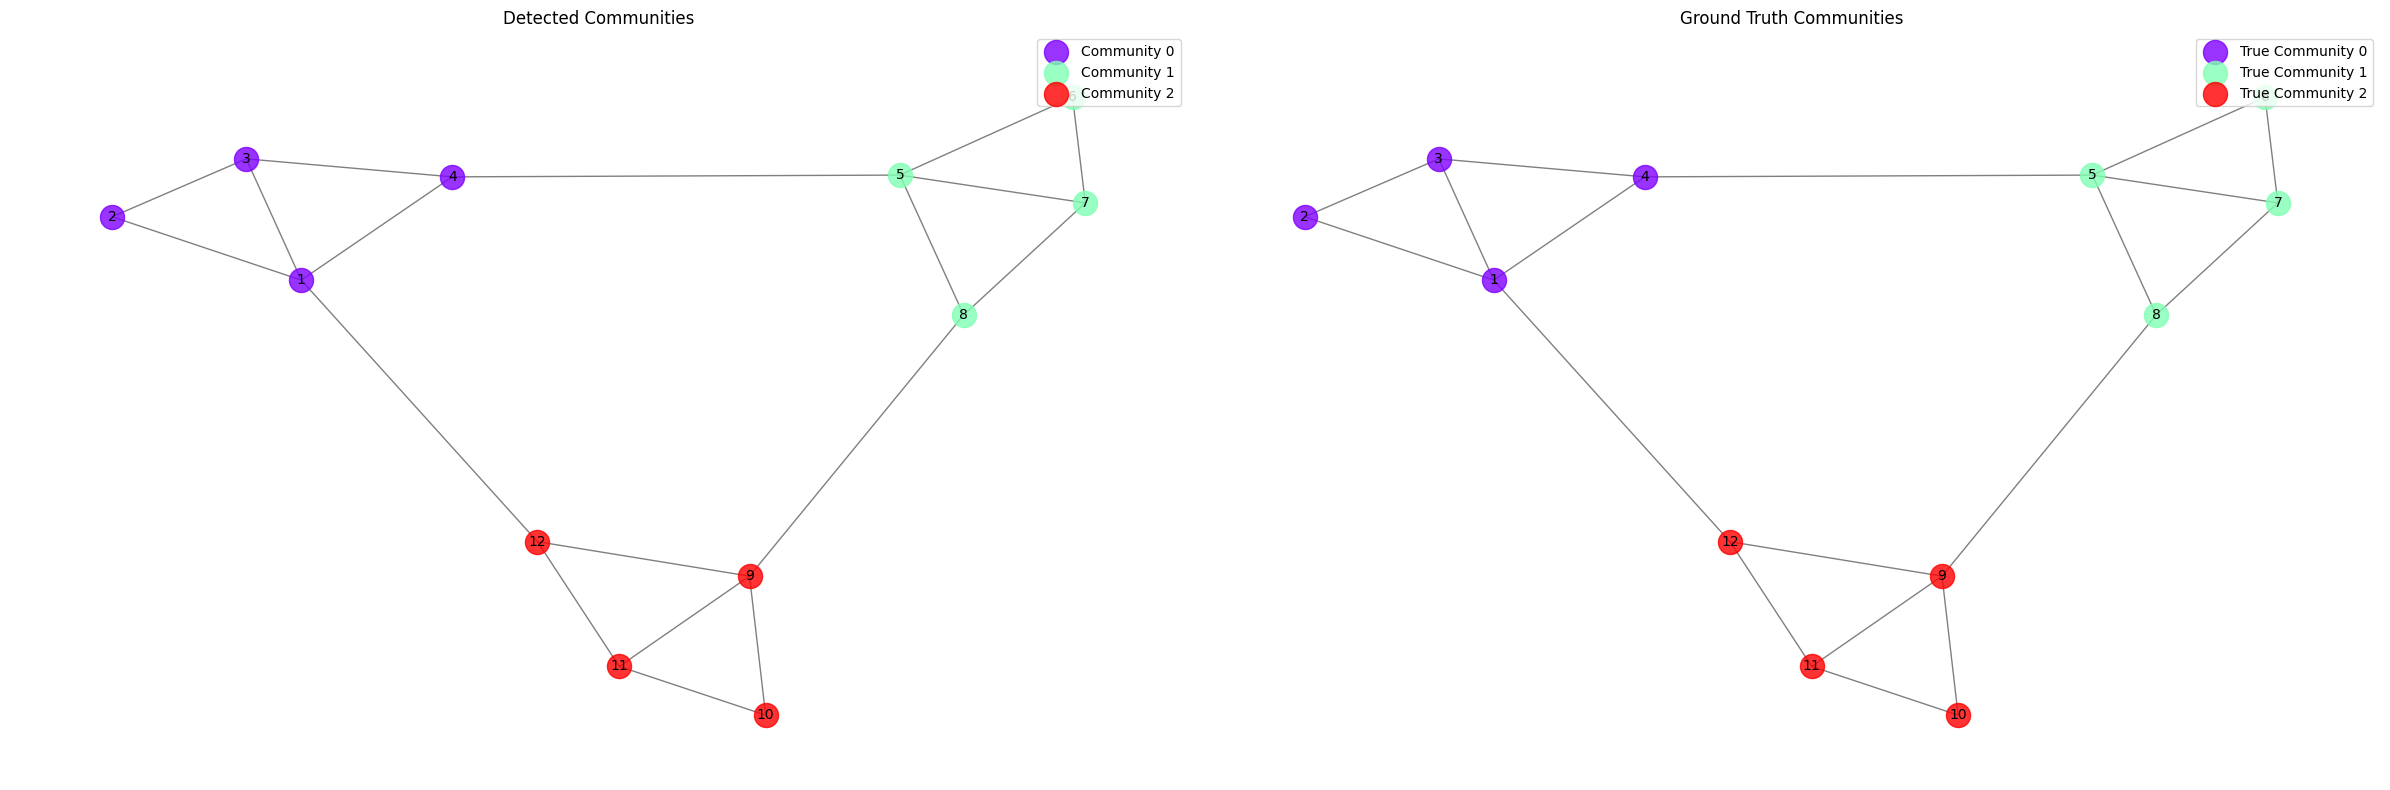

In [7]:
# Create the graph
G_undirected = nx.Graph()
nodes = list(range(1, 13))
G_undirected.add_nodes_from(nodes)

# Cluster A: nodes 1-4
edges_clusterA = [(1,2,3), (2,3,3), (3,4,3), (4,1,3), (1,3,2)]
# Cluster B: nodes 5-8
edges_clusterB = [(5,6,3), (6,7,3), (7,8,3), (8,5,3), (5,7,2)]
# Cluster C: nodes 9-12
edges_clusterC = [(9,10,3), (10,11,3), (11,12,3), (12,9,3), (9,11,2)]
# Inter-cluster edges
inter_edges = [(4,5,1), (8,9,1), (12,1,1)]

for u, v, w in edges_clusterA + edges_clusterB + edges_clusterC + inter_edges:
    G_undirected.add_edge(u, v, weight=w)

# Ground truth for validation
ground_truth = {
    **{i: 0 for i in range(1, 5)},  # Cluster A: nodes 1-4
    **{i: 1 for i in range(5, 9)},  # Cluster B: nodes 5-8
    **{i: 2 for i in range(9, 13)}  # Cluster C: nodes 9-12
}

detector = GameTheoreticCommunityDetection(G_undirected)
partition = detector.run(init_method="singleton")

# Calculate metrics
metrics = detector.calculate_community_metrics(ground_truth=ground_truth)
print("\nCommunity Metrics:")
print(f"Number of communities: {metrics['num_communities']}")
print(f"Community sizes: {metrics['sizes']}")
print(f"Communities: {[sorted(metrics['communities'][i]) for i in range(metrics['num_communities'])]}")
print(f"Modularity: {metrics['modularity']:.4f}")
print(f"Normalized Mutual Information (NMI): {metrics['nmi']:.4f}")
print(f"Adjusted Rand Index (ARI): {metrics['ari']:.4f}")
print(f"Average internal density: {np.mean(metrics['internal_densities']):.4f}")
print(f"Average external density: {np.mean(metrics['external_densities']):.4f}")

# Visualize the results
plt = detector.visualize(ground_truth=ground_truth)